<a href="https://colab.research.google.com/github/Ripunjaykumar/Benign-Malignant-Detection/blob/main/TransferLearning_DataAugmentation_to_classify_SkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Library Imported

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report

#Check GPU availability

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Unzip the dataset

In [10]:
#!unzip "/content/gdrive/MyDrive/Vision_Project/data.zip"

#Training samples

In [4]:
benign_train_len = len( os.listdir('/content/data/train/benign'))
malignant_train_len = len(os.listdir('/content/data/train/malignant'))
train_data_len = benign_train_len + malignant_train_len
print("Number of benign samples :{}".format(benign_train_len))
print("Number of malignant samples : {}".format(malignant_train_len))
print("Total training samples : {}".format(train_data_len))

Number of benign samples :1440
Number of malignant samples : 1197
Total training samples : 2637


#Validation Samples

In [5]:
benign_test_len = len( os.listdir('/content/data/test/benign'))
malignant_test_len = len(os.listdir('/content/data/test/malignant'))
test_data_len = benign_test_len + malignant_test_len
print("Number of benign samples :{}".format(benign_test_len))
print("Number of malignant samples : {}".format(malignant_test_len))
print("Total training samples : {}".format(test_data_len))

Number of benign samples :360
Number of malignant samples : 300
Total training samples : 660


#Variables

In [6]:
IMG_SIZE = (224,224)
IMG_SHAPE = (224,224,3)
train_data_dir =       '/content/data/train'
validation_data_dir =  '/content/data/test'
nb_train_samples =     train_data_len
nb_validation_samples = test_data_len
units = 256
epochs = 30
base_learning_rate = 0.001
batch_size = 32        

#Data augmentation on a single image

In [7]:
sample_generator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range= 60,                                 
                                   fill_mode='nearest')

Orginal Image without augmentation


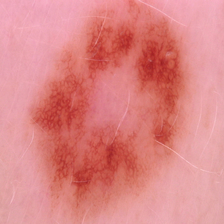

In [ ]:
image = load_img('/content/gdrive/MyDrive/Vision_Project/b.jpg', target_size=(224, 224))
print("Orginal Image without augmentation")
image

In [ ]:
image = img_to_array(image)
image = np.expand_dims(image, 0)

In [ ]:
i = 0
for batch in sample_generator.flow(image, batch_size=1,
                          save_to_dir='/content/gdrive/MyDrive/Vision_Project/Picture/aumented_sample', 
                          save_prefix='benign', 
                          save_format='jpeg'):
    i += 1
    if i > 11:  #steps_per_epoch is not given as it's single image so we need to break it manually else it keep on running for infinite loop.
        break

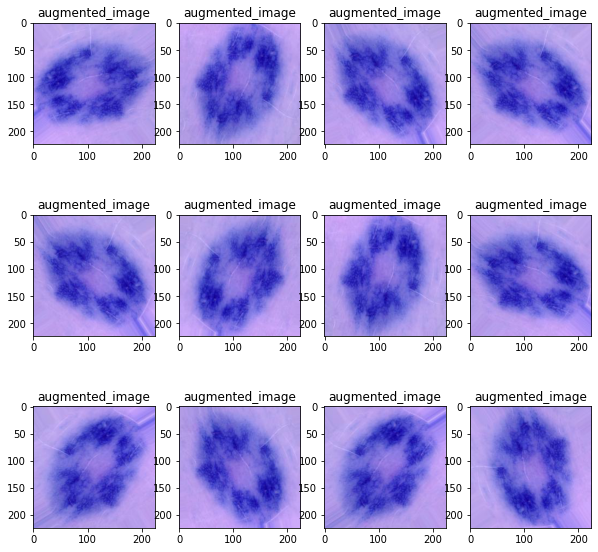

In [ ]:
i=1 # subplot index starts from 1 not 0.
plt.figure(figsize=(10, 10))
for image in os.listdir('/content/gdrive/MyDrive/Vision_Project/Picture/aumented_sample'):
    plt.subplot(3, 4, i)
    plt.imshow(load_img(os.path.join('/content/gdrive/MyDrive/Vision_Project/Picture/aumented_sample', image)))
    plt.title("augmented_image")
    i +=1  

#Types of augmentation applied on Training and Validation data

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range= 60,                                 
                                   fill_mode='nearest')
                                  
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

##Augmented Training Data

In [9]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size= IMG_SIZE,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    )


Found 2637 images belonging to 2 classes.


##Sigmoid layer predicts the probability of Class 1 - Malignant

In [ ]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [ ]:
#To get the no. of images on train_generator
train_generator.samples

2637

##Augmented Validation Data

In [10]:
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size= IMG_SIZE,
                                                              batch_size = batch_size,
                                                              class_mode = 'binary',
                                                              shuffle= False)

Found 660 images belonging to 2 classes.


In [ ]:
validation_generator.class_indices

{'benign': 0, 'malignant': 1}

#Create base model from pre-trained model

##Imagenet Pre-Trained Model - VGG16

In [11]:
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet',
                   pooling = 'avg')

58892288/58889256 [==============================] - 1s 0us/step


##Freez all trainable layers

In [12]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
print("Output shape base model : {}".format(base_model.output_shape))
print("Total layers : {}".format(len(base_model.layers)))
print("Total trainable variables : {}".format(len(base_model.trainable_variables)))
print("Total trainable layers : {}".format(sum([layer.trainable for layer in base_model.layers])))

Output shape base model : (None, 512)
Total layers : 20
Total trainable variables : 0
Total trainable layers : 0


## Defining Functional Model

In [14]:
x = base_model.output
x = Dense(units=units,activation= 'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs= base_model.input,outputs= outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
print("Total layers : {}".format(len(model.layers)))
print("Total trainable variables : {}".format(len(model.trainable_variables)))
print("Total trainable layers : {}".format(sum([layer.trainable for layer in model.layers])))

Total layers : 23
Total trainable variables : 4
Total trainable layers : 3


##Model Compilation

In [16]:
model.compile(optimizer= SGD(learning_rate=base_learning_rate),
              loss= 'binary_crossentropy',
              metrics =['accuracy'])

##Model Fitting

In [17]:
history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples//batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples//batch_size,                    
                    verbose=1
                    )

Epoch 1/30
82/82 [==============================] - 70s 422ms/step - loss: 0.8069 - accuracy: 0.6349 - val_loss: 0.5574 - val_accuracy: 0.7250
Epoch 2/30
82/82 [==============================] - 32s 391ms/step - loss: 0.5635 - accuracy: 0.7463 - val_loss: 0.4866 - val_accuracy: 0.7719
Epoch 3/30
82/82 [==============================] - 32s 391ms/step - loss: 0.5178 - accuracy: 0.7593 - val_loss: 0.4551 - val_accuracy: 0.7797
Epoch 4/30
82/82 [==============================] - 32s 390ms/step - loss: 0.5100 - accuracy: 0.7816 - val_loss: 0.4386 - val_accuracy: 0.7875
Epoch 5/30
82/82 [==============================] - 32s 393ms/step - loss: 0.4806 - accuracy: 0.7846 - val_loss: 0.4189 - val_accuracy: 0.8109
Epoch 6/30
82/82 [==============================] - 33s 396ms/step - loss: 0.4601 - accuracy: 0.8012 - val_loss: 0.4107 - val_accuracy: 0.8141
Epoch 7/30
82/82 [==============================] - 32s 391ms/step - loss: 0.4402 - accuracy: 0.8069 - val_loss: 0.4078 - val_accuracy: 0.8172

##Learning curves

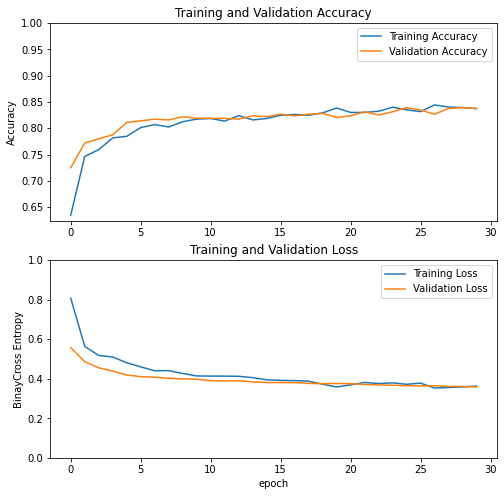

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('BinayCross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
Y_pred = model.predict(validation_generator, nb_validation_samples// batch_size+1)

In [21]:
#probaility greater than 0.5 is mapped to Class 1 - Malignant
#probaility less than or equal to 0.5 is mapped to Class 0 - Benign
y_pred = np.where(Y_pred>0.5, 1, 0)

In [22]:
print(confusion_matrix(validation_generator.classes, y_pred))

[[300  60]
 [ 47 253]]


In [24]:
print(classification_report(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       360
           1       0.81      0.84      0.83       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



##Save the Model

In [25]:
model.save('/content/gdrive/MyDrive/Vision_Project/Base_Model/my_model') #Save the model in a tensorflow format as SavedModel.

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Vision_Project/Base_Model/my_model/assets


#Fine tuning

##Un-freeze the trainable layers

In [26]:
base_model.trainable = True

In [27]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
print("Total layers : {}".format(len(model.layers)))
print("Total trainable variables : {}".format(len(model.trainable_variables)))
print("Total trainable layers : {}".format(sum([layer.trainable for layer in model.layers])))

Total layers : 23
Total trainable variables : 30
Total trainable layers : 23


In [ ]:
print(base_model.layers[4])
base_model.layers[4].trainable

True

##Fine-tune from 15th layer onwards

In [28]:
fine_tune_layer = 15
for layer in base_model.layers[:fine_tune_layer]:
  layer.trainable=False

In [29]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d True
20 dense True
21 dropout True
22 dense_1 True


In [ ]:
print("Total layers : {}".format(len(model.layers)))
print("Total trainable variables : {}".format(len(model.trainable_variables)))
print("Total trainable layers : {}".format(sum([layer.trainable for layer in model.layers])))

Total layers : 23
Total trainable variables : 10
Total trainable layers : 8


##Model Compilation

In [30]:
model.compile(optimizer= SGD(learning_rate=base_learning_rate/10),
              loss= 'binary_crossentropy',
              metrics =['accuracy'])

##Fitting Model

In [31]:
fine_tunned_history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples//batch_size,
                    epochs= epochs,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples//batch_size,               
                    verbose=1
                     )

Epoch 1/30
82/82 [==============================] - 35s 403ms/step - loss: 0.3503 - accuracy: 0.8484 - val_loss: 0.3532 - val_accuracy: 0.8422
Epoch 2/30
82/82 [==============================] - 33s 402ms/step - loss: 0.3363 - accuracy: 0.8491 - val_loss: 0.3492 - val_accuracy: 0.8438
Epoch 3/30
82/82 [==============================] - 33s 400ms/step - loss: 0.3382 - accuracy: 0.8503 - val_loss: 0.3458 - val_accuracy: 0.8438
Epoch 4/30
82/82 [==============================] - 33s 400ms/step - loss: 0.3524 - accuracy: 0.8426 - val_loss: 0.3438 - val_accuracy: 0.8453
Epoch 5/30
82/82 [==============================] - 33s 402ms/step - loss: 0.3475 - accuracy: 0.8461 - val_loss: 0.3401 - val_accuracy: 0.8438
Epoch 6/30
82/82 [==============================] - 33s 402ms/step - loss: 0.3347 - accuracy: 0.8495 - val_loss: 0.3375 - val_accuracy: 0.8531
Epoch 7/30
82/82 [==============================] - 33s 402ms/step - loss: 0.3330 - accuracy: 0.8514 - val_loss: 0.3364 - val_accuracy: 0.8531

##Learning curves

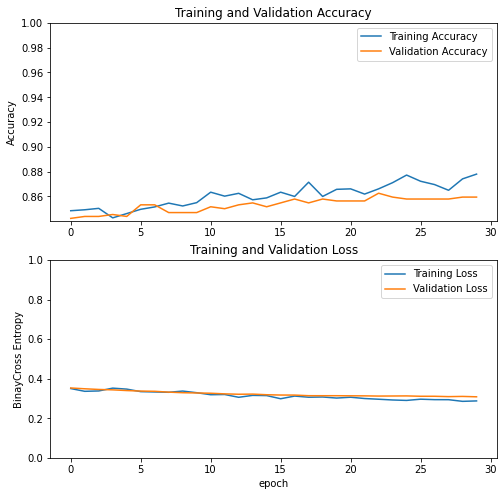

In [32]:
acc = fine_tunned_history.history['accuracy']
val_acc = fine_tunned_history.history['val_accuracy']

loss = fine_tunned_history.history['loss']
val_loss = fine_tunned_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('BinayCross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
model.save('/content/gdrive/MyDrive/Vision_Project/Fine_Tunned_Model/my_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Vision_Project/Fine_Tunned_Model/my_model/assets


##y_true

In [34]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

##y_predicted

In [35]:
Y_pred = model.predict(validation_generator, nb_validation_samples// batch_size+1)

In [ ]:
print("validation_generator_classess_len : {}".format(len(validation_generator.classes)))
print("Y_pred_len : {}".format(len(Y_pred)))

validation_generator_classess_len : 660
Y_pred_len : 660


In [36]:
#probaility greater than 0.5 is mapped to Class 1 - Malignant
#probaility less than or equal to 0.5 is mapped to Class 0 - Benign
y_pred = np.where(Y_pred>0.5, 1, 0)

##Confusion Matrix

In [37]:
print(confusion_matrix(validation_generator.classes, y_pred))

[[311  49]
 [ 43 257]]


In [38]:
print(classification_report(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       360
           1       0.84      0.86      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



##Local testing on single image

In [3]:
from tensorflow.keras.models import load_model
trained_model = load_model('/content/gdrive/MyDrive/Vision_Project/Fine_Tunned_Model/my_model')

In [8]:
image = load_img('/content/gdrive/MyDrive/Vision_Project/b.jpg', target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, 0)
image = preprocess_input(image)

In [9]:
prediction = trained_model.predict(image)
prediction

array([[0.01620895]], dtype=float32)

##Tensorflow Server Deployed on Kubernetes

In [ ]:
import requests
import json

In [ ]:
#The cluster on the Kubernetes has been deleted due to the cost. So this REST API doesn't work.
url = "http://35.244.9.223:8501/v1/models/vgg:predict"

In [ ]:
image = load_img('/content/gdrive/MyDrive/Vision_Project/b.jpg', target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, 0)
image = preprocess_input(image)

In [ ]:
def make_prediction(instances):
   data = json.dumps({"instances": instances.tolist()}) #converting dictionary to json
   headers = {"content-type": "application/json"} # input and output format is json
   json_response = requests.post(url, data=data, headers=headers)
   predictions = json.loads(json_response.text)['predictions'] #converting json to dictionary i.e we are able to aceese ['predictions']
   return predictions

In [ ]:
predictions = make_prediction(image)

In [ ]:
type(predictions)

list

In [ ]:
predictions[0][0]

0.0216563642